# Homework 7

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence except for 2 of the entries, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [1]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

In [62]:
x,y= addition_problem()

torch.Size([50, 2, 1])


Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

class AttentionPooling(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(AttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, attention_dim)
        self.q = nn.Parameter(torch.randn(attention_dim))
        self.softmax = nn.Softmax()

    def forward(self, h):
        e_t = torch.matmul(torch.tanh(self.W(h)), self.q)
        e_t = e_t.unsqueeze(0) if e_t.dim() == 1 else e_t
        #print(e_t.shape)
        alpha_t = self.softmax(e_t)
        return  torch.sum(h * alpha_t.unsqueeze(-1), dim=1)

class AdditionNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AdditionNet, self). __init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.attention = AttentionPooling(hidden_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dense1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.attention(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        return x

if torch.cuda.is_available():
 device = "cuda:0"
else:
 device = "cpu"


In [160]:
X, y = addition_problem()
input_dim = X.shape[1]
model = AdditionNet(input_dim, 64)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30000
validation_loss = []
for epoch in range(EPOCHS):

    #load training data
    X_train, y_train = addition_problem()
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor([y_train], dtype=torch.float32).to(device)
    #train
    model.train()
    optimizer.zero_grad()
    outputs_train = model(X_train)
    train_loss = criterion(outputs_train, y_train)
    train_loss.backward()
    optimizer.step()
    #load valdiation data
    X_val, y_val = addition_problem()
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor([y_val], dtype=torch.float32).to(device)
    #validate
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val)
        val_loss = criterion(outputs_val, y_val)
        validation_loss.append(val_loss.item())


    if epoch % 1000 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Training loss: {train_loss.item()}, Validation loss: {val_loss.item()}")


Epoch [1/30000], Training loss: 0.012641029432415962, Validation loss: 4.016443926957436e-05
Epoch [1001/30000], Training loss: 0.043585773557424545, Validation loss: 0.24100616574287415
Epoch [2001/30000], Training loss: 0.04439060017466545, Validation loss: 0.015423712320625782
Epoch [3001/30000], Training loss: 0.012097177095711231, Validation loss: 0.17862620949745178
Epoch [4001/30000], Training loss: 0.006495403125882149, Validation loss: 0.005633289460092783
Epoch [5001/30000], Training loss: 2.878401573980227e-05, Validation loss: 0.001853450550697744
Epoch [6001/30000], Training loss: 0.0001405157381668687, Validation loss: 0.00021780532551929355
Epoch [7001/30000], Training loss: 0.0003618178889155388, Validation loss: 8.520203118678182e-05
Epoch [8001/30000], Training loss: 2.4126904463628307e-05, Validation loss: 4.958543513566838e-07
Epoch [9001/30000], Training loss: 0.0001601198746357113, Validation loss: 6.0272126575000584e-05
Epoch [10001/30000], Training loss: 6.44792

By observing the displayed validation loss logs and validation loss plot we verify that the model achieves $MSE < 0.05$.

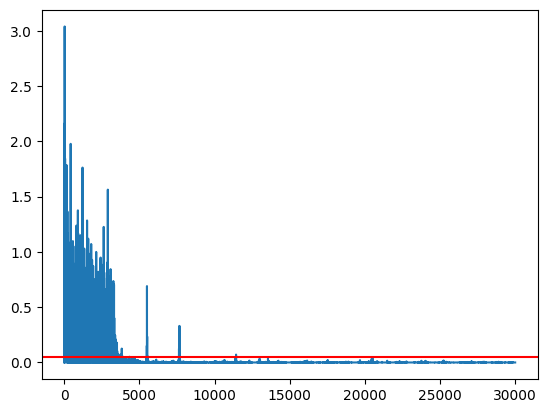

In [161]:
plt.plot(validation_loss)
plt.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()

In [162]:
lengths= [50,55,65,80,100,125,150]

for len in lengths:
    MSE = 0
    for i in range(100):
        x, y = addition_problem(len)
        x = torch.Tensor(x).to(device)
        y = torch.Tensor(y).to(device)
        model.eval()
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            MSE += loss.item()
            #print(loss.item())
    MSE = MSE/100
    print(f"MSE for length {len} is {MSE}")




MSE for length 50 is 3.430476771441704e-05
MSE for length 55 is 3.125289208821158e-05
MSE for length 65 is 2.6328903410126614e-05
MSE for length 80 is 3.403158957309471e-05
MSE for length 100 is 2.2096396479478477e-05
MSE for length 125 is 2.3590429293491864e-05
MSE for length 150 is 3.0195941093893452e-05


We can observe that the average validation loss for 100 different sequences  also achieves $MSE < 0.05$, generalizing for longer sequences.